**Contents**

- [Introduction](#Introduction)
- [Time-varying input](#Time-varying-input)
- [Constant input](#Constant-input)

## Introduction

This system is a continuous linear time-invariant system $x' = Ax + Bu$ proposed as a benchmark in ARCH 2016 as "International Space Station (ISS)". 

The ISS state-space model is a structural model of component 1R (Russian service module) of the International Space Station. It has 270 state variables with three inputs.

In [1]:
using SX, Reachability, MAT, Plots

INFO: Recompiling stale cache file /Users/forets/.julia/lib/v0.6/Reachability.ji for module Reachability.


## Time-varying input <a id='Time-varying-input'> </a>

Build the scenario as an initial value problem with non-deterministic inputs:

In [2]:
file = matopen("iss.mat")
A, B = sparse(read(file, "A")), read(file, "B");
C = reshape(full(read(file, "C")[3, :]), (1, 270));
Cvec = C[1, :]
time_horizon = 20.0;
X0 = BallInf(zeros(size(A, 1)), 0.0001) # -0.0001 <= xi <= 0.0001 for all i
U = Hyperrectangle(low=[0.0, 0.8, 0.9], high=[0.1, 1., 1.]) # input set

S = ConstrainedLinearControlContinuousSystem(A, eye(A), nothing, ConstantInput(B * U));
problem_TV = InitialValueProblem(S, X0);

#### Dense time reachability plot:

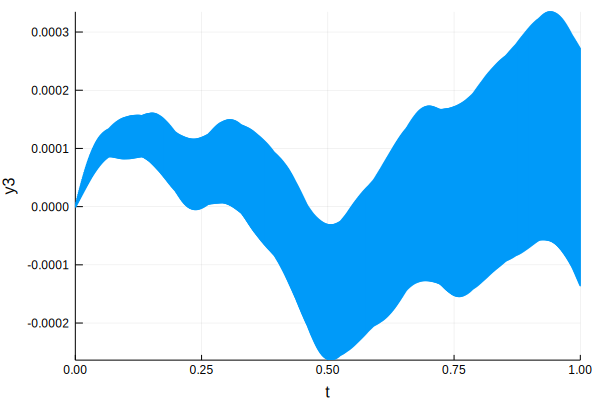

In [3]:
sol = solve(problem_TV, :T=>1.0, :δ=>1e-3, :vars=> 1:270, :plot_vars=>[0, 270], :projection_matrix=>C, :assume_sparse => true);
plot(sol, xlabel="t", ylabel="y3")

#### Discrete time reachability plot:

In [ ]:
sol = solve(problem_TV, :approx_model=>"nobloating", :T=>1.0, :δ=>1e-3, :vars=> 1:270, :plot_vars=>[0, 270], :projection_matrix=>C, :assume_sparse => true);
plot(sol, xlabel="t", ylabel="y3")

#### Check mode

For the time-varying case, the specification $y_3 \in [-0.0005, 0.0005]$ should be violated around time ~13.7, whereas the specification $y_3 \in [-0.0007, 0.0007]$ is safe.

In [ ]:
y3SPEC1 = LinearConstraintProperty([Clause(LinearConstraint(Cvec, 0.0005)), 
                                    Clause(LinearConstraint(-Cvec, 0.0005))])
y3SPEC2 = LinearConstraintProperty([Clause(LinearConstraint(Cvec, 0.0007)), 
                                    Clause(LinearConstraint(-Cvec, 0.0007))]);

In [ ]:
sol = solve(problem_TV, :T=>time_horizon, :δ=>1e-3, :vars=> 136:270, :mode=>"check", :property=>y3SPEC1,
                        :projection_matrix=>C, :assume_sparse => true);
sol.satisfied, sol.violation

In [ ]:
sol = solve(problem_TV, :T=>time_horizon, :δ=>1e-3, :vars=> 136:270, :mode=>"check", :property=>y3SPEC2,
                        :projection_matrix=>C, :assume_sparse => true);
sol.satisfied, sol.violation

## Constant input <a id='Constant-input'> </a>

In [4]:
import Reachability.add_dimension
A = sparse(read(file, "A"))
Aext = add_dimension(add_dimension(add_dimension(A)))
Aext[1:270, 271:273] = B
Aext = sparse(Aext)
S = LinearContinuousSystem(Aext);

X0 = X0 * U
problem_CONST = InitialValueProblem(S, X0);
C = hcat(C, reshape(fill(0.0, 3), (1, 3)));
Cvec = C[1, :]
size(S.A), dim(X0), size(C)

((273, 273), 273, (1, 273))

#### Check mode

In the constant-input case, the specification $y_3 \in [-0.00017, 0.00017]$ is violated around time ~0.5, whereas the specification $y_3 \in [-0.0005, 0.0005]$ is safe.

In [5]:
y3SPEC3 = LinearConstraintProperty([Clause(LinearConstraint(Cvec, 0.00017)), 
                                    Clause(LinearConstraint(-Cvec, 0.00017))])
y3SPEC4 = LinearConstraintProperty([Clause(LinearConstraint(Cvec, 0.0005)), 
                                    Clause(LinearConstraint(-Cvec, 0.0005))]);

In [6]:
sol = solve(problem_CONST, :T=>time_horizon, :δ=>1e-3, :vars=> 136:270, :mode=>"check", :property=>y3SPEC3,
                           :projection_matrix=>C, :assume_sparse => true, :assume_homogeneous=>true);
sol.satisfied, sol.violation

Computing successors   2%|█                             |  ETA: 0:00:48

(false, 489)

In [7]:
sol = solve(problem_CONST, :T=>time_horizon, :δ=>1e-3, :vars=> 136:270, :mode=>"check", :property=>y3SPEC4,
                           :projection_matrix=>C, :assume_sparse => true, :assume_homogeneous=>true);
sol.satisfied, sol.violation

Computing successors 100%|██████████████████████████████| Time: 0:00:47


(true, -1)